In [40]:
#import necessary package
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import kagglehub

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

In [41]:
from sklearn.preprocessing import RobustScaler
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
df = pd.read_csv(f"{path}/creditcard.csv")
df['Class'] = df['Class'].astype(int)
# prepare data
df.drop('Time', axis=1, inplace=True)
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
X = df.drop('Class', axis=1).values
y = df['Class'].values

# 只用正常樣本訓練 Autoencoder
# normal_data = data[data['Class'] == 0]
# fraud_data = data[data['Class'] == 1]

In [42]:
#欠抽樣正常樣本
from sklearn.utils import resample
normal = X[y == 0]
fraud = X[y == 1]
normal_down = resample(normal, replace=False, n_samples=len(fraud), random_state=RANDOM_SEED)
X_resampled = np.vstack([normal_down, fraud])
y_resampled = np.hstack([np.zeros(len(fraud)), np.ones(len(fraud))])


In [ ]:
!pip install imbalanced-learn

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#非監督式學習(Kmeans)
# 分割訓練與測試資料集
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y_resampled
)


# PCA
pca = PCA().fit(X_train)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [36]:
!pip install optuna

In [53]:
# 嘗試不同的聚類數量
best_f1 = -1
best_k = None
best_model = None
best_pred = None
#kmeans_p = {'n_clusters': 8, 'init': 'k-means++', 'n_init': 79, 'tol': 0.0007956934385770805}
kmeans_p = {'n_clusters': 8, 'init': 'k-means++', 'n_init': 39, 'tol': 0.0009019938907393534}
n_clusters = kmeans_p['n_clusters']

kmeans = KMeans(**kmeans_p, random_state=RANDOM_SEED)
kmeans.fit(X_train_pca[y_train == 0])  # 僅用正常樣本訓練

# 測試集預測
cluster_labels = kmeans.predict(X_test_pca)

# 判斷哪些 cluster 傾向是異常
fraud_rate = []
for i in range(n_clusters):
    mask = (cluster_labels == i)
    if np.sum(mask) > 0:
        rate = np.mean(y_test[mask])
    else:
        rate = 0
    fraud_rate.append(rate)

# 將異常率高於平均的 cluster 視為異常
mean_rate = np.mean(fraud_rate)
anomaly_clusters = [i for i, rate in enumerate(fraud_rate) if rate > mean_rate]
y_pred = np.isin(cluster_labels, anomaly_clusters).astype(int)

f1 = f1_score(y_test, y_pred)
if f1 > best_f1:
    best_f1 = f1
    best_model = kmeans
    best_pred = y_pred

print(f"對應 F1 分數 = {best_f1:.4f}")

對應 F1 分數 = 0.8349


In [54]:
# evaluate
# define evaluation function
def evaluation(y_true, y_pred, model_name="Autoencoder"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

evaluation(y_test, y_pred, model_name="Autoencoder")


Autoencoder Evaluation:
         Accuracy: 0.8209459459459459
  Precision Score: 0.7745664739884393
     Recall Score: 0.9054054054054054
         F1 Score: 0.8348909657320872

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.74      0.80       148
         1.0       0.77      0.91      0.83       148

    accuracy                           0.82       296
   macro avg       0.83      0.82      0.82       296
weighted avg       0.83      0.82      0.82       296



In [17]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.1 MB/s eta 0:00:00


In [52]:
import optuna
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
import numpy as np
import pandas as pd

# === Optuna 貝葉斯優化 ===
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    init = trial.suggest_categorical("init", ['k-means++', 'random'])
    n_init = trial.suggest_int("n_init", 10, 100)
    tol = trial.suggest_float("tol", 1e-5, 1e-2, log=True)

    model = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        tol=tol,
        random_state=42
    )

    model.fit(X_train_pca[y_train == 0])  # 用正常樣本訓練
    test_labels = model.predict(X_test_pca)

    # 計算 cluster 詐欺率
    fraud_rate = []
    for i in range(n_clusters):
        mask = (test_labels == i)
        rate = np.mean(y_test[mask]) if np.sum(mask) > 0 else 0
        fraud_rate.append(rate)

    threshold = np.mean(fraud_rate)
    anomaly_clusters = [i for i, r in enumerate(fraud_rate) if r > threshold]
    y_pred = np.isin(test_labels, anomaly_clusters).astype(int)

    return f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("最佳參數：", study.best_trial.params)
print("最佳 F1 分數：", study.best_value)

# 繪圖（可選）
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


[I 2025-05-29 12:07:08,642] A new study created in memory with name: no-name-eb5f71ab-0dce-45cc-896e-3220c3d54f26
[I 2025-05-29 12:07:08,757] Trial 0 finished with value: 0.6339869281045751 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 71, 'tol': 0.0025441109994123468}. Best is trial 0 with value: 0.6339869281045751.
[I 2025-05-29 12:07:08,965] Trial 1 finished with value: 0.765625 and parameters: {'n_clusters': 6, 'init': 'k-means++', 'n_init': 87, 'tol': 0.0006798993532628656}. Best is trial 1 with value: 0.765625.
[I 2025-05-29 12:07:09,028] Trial 2 finished with value: 0.2413793103448276 and parameters: {'n_clusters': 5, 'init': 'random', 'n_init': 53, 'tol': 9.787839951893345e-05}. Best is trial 1 with value: 0.765625.
[I 2025-05-29 12:07:09,111] Trial 3 finished with value: 0.2413793103448276 and parameters: {'n_clusters': 5, 'init': 'random', 'n_init': 62, 'tol': 0.0007488257853381239}. Best is trial 1 with value: 0.765625.
[I 2025-05-29 12:07:09,171] Trial 4 fin

最佳參數： {'n_clusters': 8, 'init': 'k-means++', 'n_init': 39, 'tol': 0.0009019938907393534}
最佳 F1 分數： 0.8348909657320872


In [ ]:
def compare_scores(score_set1, score_set2, set1_name="Set 1", set2_name="Set 2"):
    """
    比較兩組分數並計算差值。

    Args:
        score_set1 (object): 包含 Accuracy, Precision, Recall, F1 屬性的物件或字典。
        score_set2 (object): 包含 Accuracy, Precision, Recall, F1 屬性的物件或字典。
        set1_name (str): 第一組分數的名稱。
        set2_name (str): 第二組分數的名稱。
    """
    scores_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1']
    differences = {}

    print(f"\nComparing {set1_name} and {set2_name}:")
    print("===" * 15)

    for score_name in scores_to_compare:
        try:
            score1 = getattr(score_set1, score_name) if not isinstance(score_set1, dict) else score_set1[score_name]
            score2 = getattr(score_set2, score_name) if not isinstance(score_set2, dict) else score_set2[score_name]
            difference = score2 - score1
            differences[score_name] = difference
            print(f"{score_name} Difference ({set2_name} - {set1_name}): {difference:.6f}")
        except (AttributeError, KeyError):
            print(f"Warning: '{score_name}' not found in one or both score sets.")

# 使用範例:
# 範例分數
class ScoreSet1:
    Accuracy = 0.9996371850239341
    Precision = 0.9411764705882353
    Recall = 0.8235294117647058
    F1 = 0.8784313725490196

# 假設你有第二組分數 (你可以替換成其他模型的結果)
class ScoreSet2:
    Accuracy =  0.9996839998595555
    Precision = 0.957983193277311
    Recall = 0.8382352941176471
    F1 = 0.8941176470588236
class Set3:
    Accuracy= 0.9997074072773662
    Precision = 0.9512195121951219
    Recall = 0.8602941176470589
    F1 = 0.9034749034749034

compare_scores(Set3, ScoreSet2, set1_name="eg Model", set2_name="my Model")


Comparing eg Model and my Model:
Accuracy Difference (my Model - eg Model): -0.000023
Precision Difference (my Model - eg Model): 0.006764
Recall Difference (my Model - eg Model): -0.022059
F1 Difference (my Model - eg Model): -0.009357


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print("Best threshold by Youden's index:", best_threshold)

# 用這個 threshold 再評估
y_pred = (reconstruction_error > best_threshold).astype(int)
evaluation(y_test, y_pred, model_name="Autoencoder (Youden)")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


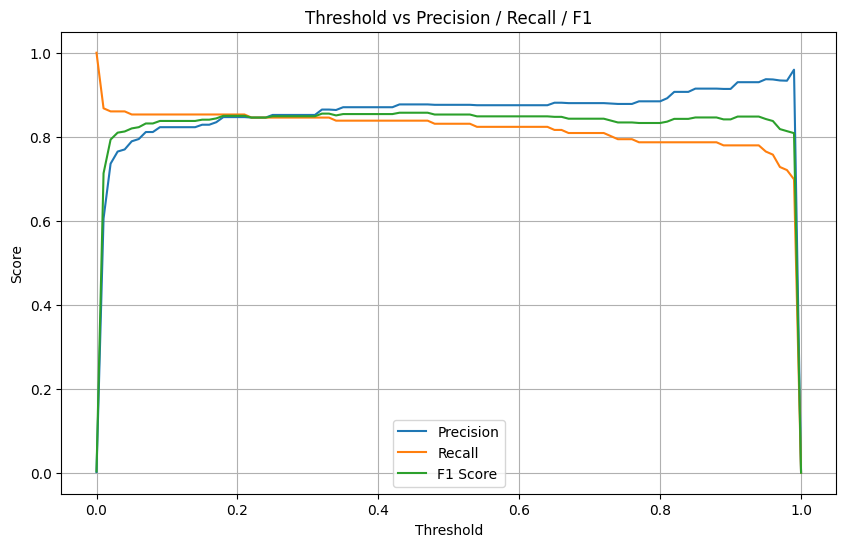

最佳閾值: 0.43, F1=0.8571, Precision=0.8769, Recall=0.8382


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_thresholds(y_true, y_proba, plot=True):
    thresholds = np.arange(0.0, 1.01, 0.01)
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(thresholds, precisions, label='Precision')
        plt.plot(thresholds, recalls, label='Recall')
        plt.plot(thresholds, f1s, label='F1 Score')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Threshold vs Precision / Recall / F1')
        plt.legend()
        plt.grid(True)
        plt.show()

    best_idx = np.argmax(f1s)
    print(f'最佳閾值: {thresholds[best_idx]:.2f}, F1={f1s[best_idx]:.4f}, Precision={precisions[best_idx]:.4f}, Recall={recalls[best_idx]:.4f}')

    return thresholds[best_idx], precisions[best_idx], recalls[best_idx], f1s[best_idx]

# 使用範例
y_proba = xgb_model.predict_proba(X_test)[:,1]
best_thresh, best_prec, best_rec, best_f1 = evaluate_thresholds(y_test, y_proba)


In [ ]:
#SMOTE optuma
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import optuna
from google.colab import drive
drive.mount('/content/drive')
storage_path = '/content/drive/MyDrive/optuna_study.db'

def objective_with_smote(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.2, 0.4),  # 可固定為 1 因為 SMOTE 後類別平衡
        'eval_metric': 'logloss',
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': RANDOM_SEED,
        'tree_method': 'hist',
        #'use_label_encoder': False
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    scores = []

    for train_idx, val_idx in skf.split(X_train_std, y_train):
        X_fold_train, X_fold_val = X_train_std[train_idx], X_train_std[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Apply SMOTE on current fold's training data
        # sm = SMOTE(random_state=RANDOM_SEED)
        # X_res, y_res = sm.fit_resample(X_fold_train, y_fold_train)

        model = XGBClassifier(
            **params,
            )

        model.fit(X_train_std, y_train)

        y_proba = model.predict_proba(X_fold_val)[:, 1] #預測機率

        best_score = 0
        for threshold in np.arange(0.1, 0.9, 0.05):
            y_pred = (y_proba > threshold).astype(int)
            precision = precision_score(y_fold_val, y_pred)
            recall = recall_score(y_fold_val, y_pred)
            f1 = f1_score(y_fold_val, y_pred)
            score = f1*recall* precision
            if score > best_score:
                best_score = score
        scores.append(best_score)

    return np.mean(scores)

study = optuna.create_study(
    study_name='xgboost1',  # Give your study a name
    storage='sqlite:///' + storage_path,
    load_if_exists=True,
    direction='maximize'
)
study.optimize(objective_with_smote, n_trials=300)

print("最佳參數：", study.best_params)
print("最佳 F1 分數：", study.best_value)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2025-05-29 05:23:39,996] A new study created in RDB with name: xgboost1
[I 2025-05-29 05:24:10,187] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.13021674628303642, 'n_estimators': 250, 'subsample': 0.8953104387475361, 'colsample_bytree': 0.9879194507904189, 'scale_pos_weight': 0.3946958448838549, 'gamma': 0.08189273203738356}. Best is trial 0 with value: 1.0.
[I 2025-05-29 05:24:24,794] Trial 1 finished with value: 0.6875916106699744 and parameters: {'max_depth': 6, 'learning_rate': 0.14254006427472277, 'n_estimators': 211, 'subsample': 0.8285219945407262, 'colsample_bytree': 0.9982972700637163, 'scale_pos_weight': 0.3218951182950331, 'gamma': 3.394794420002707}. Best is trial 0 with value: 1.0.
[I 2025-05-29 05:24:42,080] Trial 2 finished with value: 0.7442588270194671 and parameters: {'max_depth': 7, 'learning_rate': 0.1855480369678379, 'n_estimators': 275, 'subsample': 0.9864266551062482, 'colsample_bytree': 0.9592210841693101, 'scale_pos_w

In [ ]:
from google.colab import drive
drive.mount('/content/drive')